In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"



In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

In [5]:
length = 100000
train_length = 80000

In [6]:
max_lag = 300

In [7]:
np.random.seed(42)
X0 = 1*np.sin(np.linspace(0, length//10, length)*0.5)*cos(np.linspace(0, length//10, length)*2) + np.random.randn(length)
X1 = 1*np.sin(np.linspace(0, length//10, length)*2) + cos(np.linspace(0, length//10, length)*0.5) + np.random.randn(length)
X2 = np.random.randn(length)
X3 = np.random.randn(length)*0.1
X4 = np.random.randn(length)*0.1
X5 = np.random.randn(length)*0.1
for t in range(max_lag, length):
    X2[t] += X0[t-10]*X1[t-100] + X0[t-70]*X1[t-40]
    X3[t] += X2[t-150]*X1[t-20]-5*np.sin(X0[t-100])
    X4[t] += X3[t-80]/(20 + X2[t-40]) 
    X5[t] += X0[t-10]*X1[t-20]+X2[t-110]*X4[t-120]+X4[t-210]*X5[t-270]

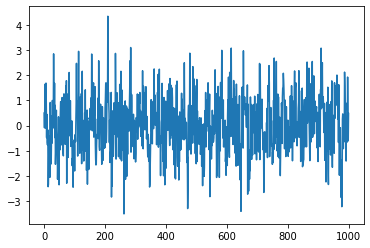

In [8]:
plt.plot(X0[:1000])

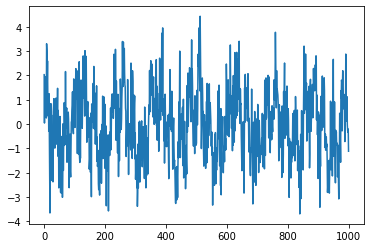

In [9]:
plt.plot(X1[:1000])

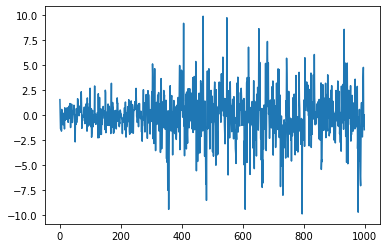

In [10]:
plt.plot(X2[:1000])

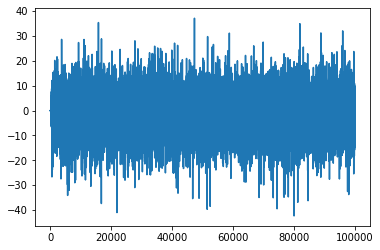

In [11]:
plt.plot(X3[:100000])

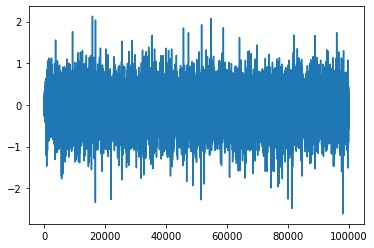

In [12]:
plt.plot(X4)

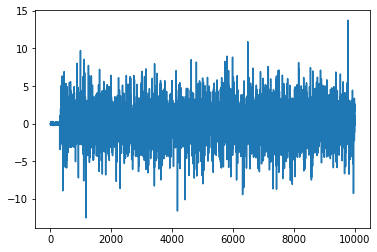

In [13]:
plt.plot(X5[:10000])


In [14]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
class TCNTemporalBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dilation):
        super().__init__()
        padding = int(dilation*(kernel_size-1))
        self.pad = nn.ConstantPad1d((padding, 0), 0)
        self.conv1 = weight_norm(nn.Conv1d(input_channels, output_channels, kernel_size, dilation=dilation))
        self.conv2 = weight_norm(nn.Conv1d(output_channels, output_channels, kernel_size, dilation=dilation))
        self.residual = nn.Conv1d(input_channels, output_channels, 1)
        
    def forward(self, x):
        out = self.pad(x)
        out = torch.relu(self.conv1(out))
        out = self.pad(out)
        out = torch.relu(self.conv2(out))
        y = self.residual(x)
        out = torch.relu(out + y)
        return out
    

class TCN(nn.Module):
    def __init__(self, input_dim, n_layers, n_channels=32, kernel_size=3):
        super().__init__()
        self.first_layer = TCNTemporalBlock(input_dim, n_channels, kernel_size, 1)
        self.tcn_layers = nn.ModuleList([TCNTemporalBlock(n_channels, n_channels, kernel_size, 2**(i+1)) for i in range(n_layers-1)])
        self.n_layers = n_layers
        self.output_transform = nn.Linear(n_channels, 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.first_layer(x)
        for i in range(self.n_layers-1):
            x = self.tcn_layers[i](x)
        x = x[..., -1]
        out = self.output_transform(x)
        return out.squeeze(1)
    
class TCNStack(nn.Module):
    def __init__(self, input_dim, n_layers, n_networks, n_channels=32, kernel_size=3):
        super().__init__()
        self.tcns = nn.ModuleList([TCN(input_dim, n_layers, n_channels, kernel_size) for _ in range(n_networks)])
        self.n_networks = n_networks
        self.output_transform = nn.Linear(self.n_networks, 1)
    def forward(self, x):
        step = x.shape[1]//self.n_networks
        outs = []
        for i in range(self.n_networks):
            out = self.tcns[i](x[:, i*step:(i+1)*step, :])
            outs.append(out.unsqueeze(1))
        outs = torch.cat(outs, dim=1)
        out = self.output_transform(outs)
        return out.squeeze(1)

In [15]:
depth = 300
epochs = 300
importance_calculation_steps = 20
early_stopping_epochs = 50


In [16]:
from tqdm import tqdm_notebook

In [17]:
X_ = np.concatenate([X0.reshape(-1, 1), 
                    X1.reshape(-1, 1),
                    X2.reshape(-1, 1),
                    X3.reshape(-1, 1),
                    X4.reshape(-1, 1),
                    X5.reshape(-1, 1)], axis=1)

In [18]:
X = np.zeros((len(X_), depth, X_.shape[1]))
for i in range(X_.shape[1]):
    for j in range(depth):
        X[:, j, i] = pd.Series(X_[:, i]).shift(depth - j - 1).bfill()

### Predicting X2

In [19]:
y = pd.Series(X2).shift(-1).ffill().values

In [20]:
X = X[max_lag:]
y = y[max_lag:]

In [21]:
X_train = X[:train_length]
X_test = X[train_length:]

y_train = y[:train_length]
y_test = y[train_length:]

In [22]:
X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

In [23]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

In [24]:
X_train_t = torch.Tensor(X_train)
X_test_t = torch.Tensor(X_test)

y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

In [25]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=256)

In [26]:
model = TCNStack(X_train_t.shape[2], 6, 6).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.001)

loss = nn.MSELoss()

In [28]:
val_loss = 999
counter = 0
for e in range(epochs):
    train_loss = 0
    model.train()
    for batch_x, batch_y in tqdm_notebook(train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y)
        l.backward()
        opt.step()
        train_loss+=l.item()*batch_x.shape[0]
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            output = model(batch_x)
            true.append(batch_y.numpy())
            preds.append(output.detach().cpu().numpy())
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    mse = mean_squared_error(true, preds)
    r2 = r2_score(true, preds)
    print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
    if val_loss > mse:
        val_loss = mse
        torch.save(model.state_dict(), "tcn_stack_nonlinear_X2.pt")
        counter = 0
    else:
        counter += 1

    if counter == early_stopping_epochs:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  0 train:  0.004736217150837183 mse:  0.004726229 r2:  0.10147033796661875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  1 train:  0.004480540407449007 mse:  0.004268602 r2:  0.18847214701004944


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  2 train:  0.004018760102242232 mse:  0.0038792256 r2:  0.2624987687835707


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  3 train:  0.003779650902748108 mse:  0.0038461746 r2:  0.2687822994052361


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  4 train:  0.003711796636134386 mse:  0.003710924 r2:  0.2944954890428112


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  5 train:  0.003668456878513098 mse:  0.0037040361 r2:  0.2958049130326649


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  6 train:  0.0035888495586812496 mse:  0.0036012225 r2:  0.3153514556877838


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  7 train:  0.00353700193092227 mse:  0.0034847127 r2:  0.3375017720112069


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  8 train:  0.003414040107652545 mse:  0.0034237888 r2:  0.34908442173310905


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  9 train:  0.0032681971162557603 mse:  0.0033011832 r2:  0.3723936227895396


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  10 train:  0.0031809038534760473 mse:  0.00323528 r2:  0.38492283426718954


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  11 train:  0.003098119340464473 mse:  0.00315421 r2:  0.40033551572678694


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  12 train:  0.0030343147978186607 mse:  0.0031100505 r2:  0.40873092669703126


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  13 train:  0.0029813205882906913 mse:  0.003110144 r2:  0.4087131540684953


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  14 train:  0.00294725639782846 mse:  0.003026895 r2:  0.42454005060321254


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  15 train:  0.0029048734668642284 mse:  0.0029994056 r2:  0.4297662439930542


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  16 train:  0.002877172865718603 mse:  0.0030723277 r2:  0.4159026087721698


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  17 train:  0.0028785071197897196 mse:  0.0030196295 r2:  0.42592139114557803


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  18 train:  0.0028398727402091026 mse:  0.0030062224 r2:  0.4284702396140514


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  19 train:  0.0028160881891846658 mse:  0.0029672803 r2:  0.43587377892176615


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  20 train:  0.0028072852544486523 mse:  0.0029838795 r2:  0.4327180224489783


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  21 train:  0.0027936466991901397 mse:  0.0029432112 r2:  0.44044964362867967


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  22 train:  0.0027669579319655893 mse:  0.0029168641 r2:  0.4454586764206391


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  23 train:  0.002751225734874606 mse:  0.002925272 r2:  0.4438601451130606


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  24 train:  0.002742884796485305 mse:  0.0028802385 r2:  0.45242176767354647


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  25 train:  0.0027317266818135976 mse:  0.0028968956 r2:  0.4492549532147625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  26 train:  0.002714270642027259 mse:  0.0029128608 r2:  0.4462197494805381


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  27 train:  0.0026905479080975058 mse:  0.0028728 r2:  0.4538359477679098


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  28 train:  0.0026805034823715688 mse:  0.002885786 r2:  0.4513671104207406


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  29 train:  0.0026692551381886005 mse:  0.0028315552 r2:  0.4616772367899473


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  30 train:  0.0026337122801691295 mse:  0.002820382 r2:  0.46380144739634066


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  31 train:  0.002622973742336035 mse:  0.0027675577 r2:  0.4738441299818257


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  32 train:  0.0026039830449968576 mse:  0.0027693976 r2:  0.4734943623563007


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  33 train:  0.0025977317556738853 mse:  0.0028215253 r2:  0.4635840520501383


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  34 train:  0.002575330405682325 mse:  0.0028068603 r2:  0.4663721078963624


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  35 train:  0.0025695457629859447 mse:  0.002774856 r2:  0.4724566149174263


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  36 train:  0.002552218098193407 mse:  0.0027854256 r2:  0.47044715441088414


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  37 train:  0.0025399315156042577 mse:  0.0027824487 r2:  0.47101314345899037


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  38 train:  0.0025332228310406208 mse:  0.0028321166 r2:  0.46157054453726254


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  39 train:  0.002517787382006645 mse:  0.0028453404 r2:  0.4590564109739459


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  40 train:  0.0025184111427515744 mse:  0.00275158 r2:  0.4768817347432489


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  41 train:  0.002503431782498956 mse:  0.0028359315 r2:  0.4608452356000722


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  42 train:  0.002487323692813516 mse:  0.0027670204 r2:  0.4739462442686224


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  43 train:  0.0024799688175320624 mse:  0.0027664495 r2:  0.474054836039145


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  44 train:  0.0024764144003391266 mse:  0.0028328302 r2:  0.46143483553028863


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  45 train:  0.0024659858163446186 mse:  0.002763793 r2:  0.4745598711202227


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  46 train:  0.0024633523385971783 mse:  0.0028375175 r2:  0.46054365490963245


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  47 train:  0.002438179547339678 mse:  0.0027686278 r2:  0.47364065544244427


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  48 train:  0.0024354808174073695 mse:  0.0028055483 r2:  0.46662149830888844


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  49 train:  0.0024376922771334646 mse:  0.0028215211 r2:  0.463584855421326


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  50 train:  0.002410778371244669 mse:  0.0027974218 r2:  0.46816650150051575


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  51 train:  0.0024198880206793547 mse:  0.0028139004 r2:  0.4650336743802195


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  52 train:  0.0023916961710900068 mse:  0.0027877963 r2:  0.4699964698387801


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  53 train:  0.002387413117662072 mse:  0.0028250772 r2:  0.4629087912512103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  54 train:  0.002379429464787245 mse:  0.0027882406 r2:  0.4699119780954464


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  55 train:  0.0023608626458793878 mse:  0.0028767597 r2:  0.45308310457047274


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  56 train:  0.0023592008542269467 mse:  0.002877042 r2:  0.45302948238053586


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  57 train:  0.002348325665295124 mse:  0.0029065458 r2:  0.4474203252099592


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  58 train:  0.002331981672719121 mse:  0.0028858099 r2:  0.451362592066162


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  59 train:  0.0023342822764068844 mse:  0.0028906246 r2:  0.4504471871073188


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  60 train:  0.0023133698638528586 mse:  0.0029109363 r2:  0.4465855817090274


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  61 train:  0.002299910569563508 mse:  0.0028433516 r2:  0.4594345316964419


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  62 train:  0.002296756861358881 mse:  0.0028639077 r2:  0.4555264423158297


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  63 train:  0.002289479499682784 mse:  0.00287446 r2:  0.4535203501075239


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  64 train:  0.0022743026237934828 mse:  0.0029124913 r2:  0.44628997474057275


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  65 train:  0.0022519136838614943 mse:  0.0029297848 r2:  0.44300228586748236


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  66 train:  0.0022471906542778017 mse:  0.0029393209 r2:  0.4411892894830408


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  67 train:  0.002249179767817259 mse:  0.002985807 r2:  0.4323515244063303


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  68 train:  0.002228619360551238 mse:  0.003013024 r2:  0.4271771391734597


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  69 train:  0.0022086735934019087 mse:  0.0029333464 r2:  0.4423251275865435


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  70 train:  0.0021997906990349294 mse:  0.002932689 r2:  0.44245010657714035


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  71 train:  0.0021852910069748758 mse:  0.0029373602 r2:  0.4415620302567943


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  72 train:  0.0021787760324776173 mse:  0.0029680643 r2:  0.43572467607147936


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  73 train:  0.002174823536351323 mse:  0.0029712298 r2:  0.43512290127048436


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  74 train:  0.0021453952927142383 mse:  0.0029926042 r2:  0.4310593006307364


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  75 train:  0.0021304875705391167 mse:  0.0030092075 r2:  0.4279027009248667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  76 train:  0.002116981865465641 mse:  0.0030329996 r2:  0.423379492120329


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  77 train:  0.0020993396937847137 mse:  0.0029603445 r2:  0.4371923412316381


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  78 train:  0.0020907882172614338 mse:  0.0030068525 r2:  0.42835047074677857


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  79 train:  0.002075860997289419 mse:  0.0030578116 r2:  0.4186622877291901


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  80 train:  0.002071278075501323 mse:  0.0030166334 r2:  0.4264909868256481


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  81 train:  0.002055230464041233 mse:  0.0030253418 r2:  0.42483536002765887


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  82 train:  0.0020334000255912543 mse:  0.003020061 r2:  0.42583931703922895


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  83 train:  0.002040830018557608 mse:  0.0030416562 r2:  0.4217337397402453


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  84 train:  0.0020073010683059694 mse:  0.0031551474 r2:  0.400157282034856


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  85 train:  0.001993508242815733 mse:  0.0030635046 r2:  0.41758006007901083


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  86 train:  0.0019926373049616816 mse:  0.0031552485 r2:  0.4001381471318963


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  87 train:  0.0019657919457182287 mse:  0.0031686125 r2:  0.397597371661345


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  88 train:  0.0019551752991974355 mse:  0.0030856023 r2:  0.4133788786454248


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  89 train:  0.0019540576837956906 mse:  0.0031230804 r2:  0.4062537691364404


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  90 train:  0.0019311713702976703 mse:  0.0031585281 r2:  0.39951455098990307


In [29]:
regularizer_coeff1 = 0.0005
regularizer_coeff2 = 0.00001
scaling_coeff = 0.5
importance_lr = 0.1

In [30]:
model.load_state_dict(torch.load("tcn_stack_nonlinear_X2.pt"))

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    print(M.max())
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


tensor(0.0293, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0292, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0307, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0297, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0294, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0297, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0295, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0296, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0290, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0297, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0293, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0292, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0291, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0296, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0295, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0300, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0299, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0294, device='cuda:0', grad_fn=<MaxBack

In [31]:
importance_map.max()

0.0

([<matplotlib.axis.YTick at 0x7f23fe4c5898>,
 [Text(0, 0, 'X0'),
  Text(0, 1, 'X1'),
  Text(0, 2, 'X2'),
  Text(0, 3, 'X3'),
  Text(0, 4, 'X4'),
  Text(0, 5, 'X5')])

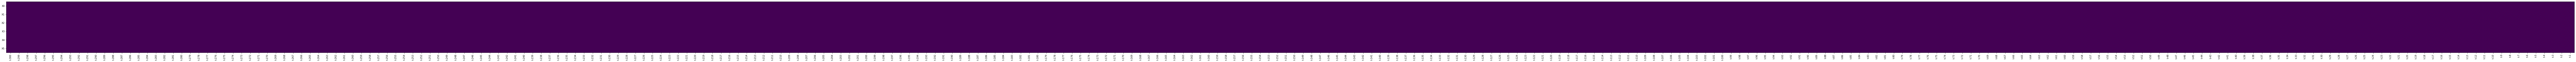

In [33]:
plt.figure(figsize=(200, 100))
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(6), ['X{}'.format(i) for i in range(6)])

### Signals with highest importance

In [ ]:
#

### True dependencies


In [51]:
#X2[t] += X0[t-10]*X1[t-100] + X0[t-70]*X1[t-40]

In [52]:
TP = 0
FP = 0
FN = 0
precision1 = TP/(TP + FP + 1e-9)
recall1 = TP/(TP + FN + 1e-9)
precision1, recall1

(0.0, 0.0)

### Predicting X3

In [34]:
y = pd.Series(X3).shift(-1).ffill().values
y = y[max_lag:]
y_train = y[:train_length]
y_test = y[train_length:]

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=256)

In [35]:
model = model = TCNStack(X_train_t.shape[2], 6, 6).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.001)

loss = nn.MSELoss()

In [36]:
val_loss = 999
counter = 0
#model.load_state_dict(torch.load("tcn_nonlinear_X3.pt"))
for e in range(epochs):
    train_loss = 0
    
    model.train()
    for batch_x, batch_y in tqdm_notebook(train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y)
        l.backward()
        opt.step()
        train_loss+=l.item()*batch_x.shape[0]
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            output = model(batch_x)
            true.append(batch_y.numpy())
            preds.append(output.detach().cpu().numpy())
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    mse = mean_squared_error(true, preds)
    r2 = r2_score(true, preds)
    print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
    if val_loss > mse:
        val_loss = mse
        torch.save(model.state_dict(), "tcn_stack_nonlinear_X3.pt")
        counter = 0
    else:
        counter += 1

    if counter == early_stopping_epochs:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  0 train:  0.004616667227447033 mse:  0.0023028685 r2:  0.4194326354710134


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  1 train:  0.0020513549227267505 mse:  0.0020794156 r2:  0.47576645082905156


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  2 train:  0.001924781733006239 mse:  0.0019077141 r2:  0.5190534935255544


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  3 train:  0.0018354229483753444 mse:  0.0018668389 r2:  0.5293583776541055


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  4 train:  0.0017976986568421125 mse:  0.0018368139 r2:  0.5369278854581297


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  5 train:  0.0017760784057900309 mse:  0.0018290738 r2:  0.5388791958257915


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  6 train:  0.0017602936206385492 mse:  0.0018202242 r2:  0.541110250959588


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  7 train:  0.001750525664910674 mse:  0.0018306667 r2:  0.5384776619769764


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  8 train:  0.0017416817706078292 mse:  0.0017999363 r2:  0.5462249354046502


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  9 train:  0.0017198992550373077 mse:  0.0017933376 r2:  0.547888549555924


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  10 train:  0.0017278422137722374 mse:  0.0017708824 r2:  0.5535495773122643


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  11 train:  0.0017132131420075894 mse:  0.0017673906 r2:  0.5544298616370592


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  12 train:  0.0017114077024161815 mse:  0.0017489458 r2:  0.5590799798545703


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  13 train:  0.001691349173337221 mse:  0.0017620027 r2:  0.5557882573153176


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  14 train:  0.0016780937135219573 mse:  0.001895573 r2:  0.5221143367362859


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  15 train:  0.001659764839336276 mse:  0.0017023119 r2:  0.5708366223310152


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  16 train:  0.0016228254936635493 mse:  0.0016876188 r2:  0.5745408771950153


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  17 train:  0.0015932218816131353 mse:  0.0017150542 r2:  0.5676242494452117


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  18 train:  0.001369727419875562 mse:  0.0011701576 r2:  0.7049960505148454


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  19 train:  0.0010622882897034288 mse:  0.0010733956 r2:  0.7293903298983428


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  20 train:  0.0010207884347066282 mse:  0.001040217 r2:  0.7377548602456238


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  21 train:  0.0010152964657172562 mse:  0.0010490835 r2:  0.7355195453525722


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  22 train:  0.0009849542185664177 mse:  0.0010338617 r2:  0.7393571078711305


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  23 train:  0.0009799763986840845 mse:  0.0010164112 r2:  0.7437564755001143


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  24 train:  0.000973346824105829 mse:  0.0010577912 r2:  0.7333243102885585


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  25 train:  0.0009618756706826389 mse:  0.0010121068 r2:  0.7448416086831435


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  26 train:  0.0009613552873022855 mse:  0.0010116432 r2:  0.7449584995719873


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  27 train:  0.0009478305451571941 mse:  0.0010362193 r2:  0.7387626873537334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  28 train:  0.0009431993165053427 mse:  0.0010347929 r2:  0.7391223111575991


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  29 train:  0.0009384716529399156 mse:  0.0009963678 r2:  0.7488095548940632


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  30 train:  0.0009315447255037725 mse:  0.0010655556 r2:  0.7313668735100232


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  31 train:  0.0009366029061377048 mse:  0.0010610619 r2:  0.7324997591362343


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  32 train:  0.0009321573719382286 mse:  0.0010381176 r2:  0.7382841696393994


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  33 train:  0.0009270122269168496 mse:  0.0010364013 r2:  0.7387168240982134


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  34 train:  0.0009271858690306545 mse:  0.0010252318 r2:  0.7415327275195296


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  35 train:  0.0009199070636183023 mse:  0.001007468 r2:  0.746011124038128


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  36 train:  0.0009146208368241787 mse:  0.0010159041 r2:  0.7438842859816008


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  37 train:  0.0009163813374936581 mse:  0.0010304243 r2:  0.7402236697794239


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  38 train:  0.0009157818452455104 mse:  0.0010132074 r2:  0.7445641517996416


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  39 train:  0.0008956364143639803 mse:  0.0010099851 r2:  0.7453764985714684


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  40 train:  0.0009043624937534332 mse:  0.0010317565 r2:  0.7398878108541307


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  41 train:  0.0009035383725538849 mse:  0.0010227768 r2:  0.7421516257656435


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  42 train:  0.0008993580777198076 mse:  0.0010220424 r2:  0.7423368315794077


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  43 train:  0.000895084016956389 mse:  0.001055766 r2:  0.7338348908853038


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  44 train:  0.0008992843793705106 mse:  0.0010725261 r2:  0.7296095620859065


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  45 train:  0.0008876732788980007 mse:  0.0010102458 r2:  0.7453107929819144


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  46 train:  0.000881264995969832 mse:  0.0010192259 r2:  0.7430468534972203


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  47 train:  0.000876032086275518 mse:  0.0010192876 r2:  0.7430313084070739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  48 train:  0.0008714178589172662 mse:  0.001064056 r2:  0.7317448995416522


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  49 train:  0.0008720403618179261 mse:  0.0010778053 r2:  0.7282786065319735


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  50 train:  0.0008730431322008372 mse:  0.0010433987 r2:  0.7369527363900845


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  51 train:  0.0008671460494399071 mse:  0.0010285933 r2:  0.7406852619636107


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  52 train:  0.000864468542020768 mse:  0.0010612449 r2:  0.7324536094972941


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  53 train:  0.000852485816553235 mse:  0.0010422462 r2:  0.7372432806029995


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  54 train:  0.0008482770333066582 mse:  0.0010858139 r2:  0.7262596007813775


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  55 train:  0.0008480282912030816 mse:  0.0010404545 r2:  0.7376950007962491


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  56 train:  0.0008436792876571417 mse:  0.0010813073 r2:  0.7273957621634459


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  57 train:  0.000835144905000925 mse:  0.0010539776 r2:  0.7342857510476486


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  58 train:  0.0008286028105765581 mse:  0.0010582452 r2:  0.7332098544834595


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  59 train:  0.0008295160269364715 mse:  0.0010494458 r2:  0.7354282256392448


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  60 train:  0.0008145562522113324 mse:  0.001058335 r2:  0.7331872035491944


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  61 train:  0.000817647659033537 mse:  0.0010598141 r2:  0.7328143160104741


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  62 train:  0.0008032030473463237 mse:  0.0010777086 r2:  0.7283030321172488


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  63 train:  0.0007992551347240805 mse:  0.0010523 r2:  0.7347087074492802


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  64 train:  0.000801530223339796 mse:  0.001116767 r2:  0.7184561696663518


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  65 train:  0.0007934353159740567 mse:  0.0010637689 r2:  0.7318172705266877


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  66 train:  0.0007786140901967884 mse:  0.0011136596 r2:  0.7192395232453778


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  67 train:  0.0007741537081077694 mse:  0.0010785646 r2:  0.7280872057964152


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  68 train:  0.0007721896158531308 mse:  0.0010947007 r2:  0.7240192033339803


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  69 train:  0.000765877337148413 mse:  0.0011153538 r2:  0.7188124155899726


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  70 train:  0.0007497955380938947 mse:  0.0011079471 r2:  0.7206796995000095


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  71 train:  0.0007502863458357751 mse:  0.0011000875 r2:  0.7226611317747926


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  72 train:  0.000738737004622817 mse:  0.0011476623 r2:  0.7106672566848435


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  73 train:  0.0007339164077304304 mse:  0.0011224245 r2:  0.7170298584818364


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  74 train:  0.0007286864830181002 mse:  0.0011171825 r2:  0.7183513815121089


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  75 train:  0.0007244456736370921 mse:  0.0011488287 r2:  0.7103731838227477


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  76 train:  0.0007109954445622861 mse:  0.0011737231 r2:  0.7040971524396169


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  77 train:  0.0007090123337693512 mse:  0.0011443623 r2:  0.7114992205816502


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  78 train:  0.0007009914938360453 mse:  0.0011082417 r2:  0.7206053943195063


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  79 train:  0.0006855752590112388 mse:  0.0011518082 r2:  0.709622063009167


In [38]:
model.load_state_dict(torch.load("tcn_stack_nonlinear_X3.pt"))

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    print(M.max())
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


tensor(0.0296, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0300, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7835, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7828, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9150, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8126, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7764, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8832, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0300, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7738, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7626, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0919, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0296, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0299, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7756, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8049, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8294, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.7712, device='cuda:0', grad_fn=<MaxBack

([<matplotlib.axis.YTick at 0x7f237cb89be0>,
 [Text(0, 0, 'X0'),
  Text(0, 1, 'X1'),
  Text(0, 2, 'X2'),
  Text(0, 3, 'X3'),
  Text(0, 4, 'X4'),
  Text(0, 5, 'X5')])

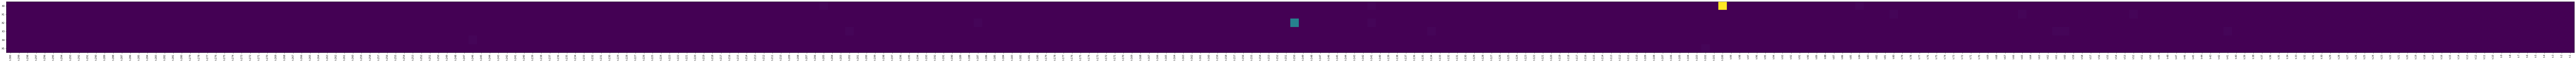

In [39]:
plt.figure(figsize=(200, 100))
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(6), ['X{}'.format(i) for i in range(6)])

### SIgnals with highest importance

In [ ]:
#X2[t-150], X0[t-100]

### True dependencies

In [53]:
#X3[t] += X2[t-150]*X1[t-20]-5*np.sin(X0[t-100])

In [54]:
TP = 2
FP = 0
FN = 1
precision3 = TP/(TP + FP + 1e-9)
recall3 = TP/(TP + FN + 1e-9)
precision3, recall3

(0.9999999995, 0.6666666664444444)

### Predicting X4

In [40]:
y = pd.Series(X4).shift(-1).ffill().values
y = y[max_lag:]
y_train = y[:train_length]
y_test = y[train_length:]

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=256)

In [41]:
model = TCNStack(X_train_t.shape[2], 6, 6).cuda()

opt = torch.optim.Adam(model.parameters(), lr=0.001)

loss = nn.MSELoss()

In [42]:
val_loss = 999
counter = 0

for e in range(epochs):
    train_loss = 0
    
    model.train()
    for batch_x, batch_y in tqdm_notebook(train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y)
        l.backward()
        opt.step()
        train_loss+=l.item()*batch_x.shape[0]
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            output = model(batch_x)
            true.append(batch_y.numpy())
            preds.append(output.detach().cpu().numpy())
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    mse = mean_squared_error(true, preds)
    r2 = r2_score(true, preds)
    print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
    if val_loss > mse:
        val_loss = mse
        torch.save(model.state_dict(), "tcn_sctck_nonlinear_X4.pt")
        counter = 0
    else:
        counter += 1

    if counter == early_stopping_epochs:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  0 train:  0.022786972569674255 mse:  0.0038630166 r2:  -0.0030921447460601215


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  1 train:  0.0037994708701968192 mse:  0.0038741708 r2:  -0.005988630991418109


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  2 train:  0.0036715550512075425 mse:  0.003622837 r2:  0.05927416428117149


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  3 train:  0.0034125927291810514 mse:  0.0036800837 r2:  0.044409146167290525


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  4 train:  0.0034244566690176726 mse:  0.0033906235 r2:  0.11957207253035118


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  5 train:  0.0033968402549624443 mse:  0.0034348213 r2:  0.10809542728983279


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  6 train:  0.0033947252061218023 mse:  0.003371799 r2:  0.12446010989211687


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  7 train:  0.0033843749832361937 mse:  0.0033657867 r2:  0.1260213045212355


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  8 train:  0.0032886227801442146 mse:  0.0026354059 r2:  0.31567596316249436


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  9 train:  0.0008736586478538811 mse:  0.0006764425 r2:  0.824351205223198


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  10 train:  0.0006597437496297061 mse:  0.00065975933 r2:  0.8286832571539131


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  11 train:  0.0006337815468199551 mse:  0.0005860002 r2:  0.847835947950909


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  12 train:  0.0006406675575301051 mse:  0.00059400586 r2:  0.8457571667824761


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  13 train:  0.0006218039584346116 mse:  0.00058128574 r2:  0.8490601514047381


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  14 train:  0.0006218033029697836 mse:  0.0005867134 r2:  0.8476507797566366


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  15 train:  0.0006144682623445988 mse:  0.0005807685 r2:  0.8491944384326829


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  16 train:  0.00062717155944556 mse:  0.00058015744 r2:  0.8493531100172209


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  17 train:  0.0006141927395947278 mse:  0.0005967485 r2:  0.8450449927596327


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  18 train:  0.0006168031487613916 mse:  0.00059267215 r2:  0.8461034842509793


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  19 train:  0.00062426948081702 mse:  0.00073907117 r2:  0.8080886955944031


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  20 train:  0.0006128398739732801 mse:  0.00057669467 r2:  0.8502522810043261


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  21 train:  0.0006110353951342404 mse:  0.0006154568 r2:  0.8401871048283057


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  22 train:  0.000607368721999228 mse:  0.00058977783 r2:  0.8468550354666348


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  23 train:  0.000605899556633085 mse:  0.00074780977 r2:  0.80581959474047


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  24 train:  0.0006054452036507428 mse:  0.00061103655 r2:  0.8413348734106043


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  25 train:  0.0006181968166492879 mse:  0.00058038154 r2:  0.8492949313913205


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  26 train:  0.0006107142442837358 mse:  0.0006049541 r2:  0.8429142824867544


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  27 train:  0.0006167474759742618 mse:  0.0005758375 r2:  0.8504748503864438


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  28 train:  0.0006012577521614731 mse:  0.00076592364 r2:  0.8011160305348739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  29 train:  0.000601334644574672 mse:  0.0006342392 r2:  0.8353099654548083


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  30 train:  0.0006033184706233442 mse:  0.0006243523 r2:  0.8378772302659426


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  31 train:  0.0005982152434065938 mse:  0.00073727436 r2:  0.8085552749442753


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  32 train:  0.0005963131481781602 mse:  0.00059447525 r2:  0.8456352766409798


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  33 train:  0.000604408222809434 mse:  0.00057932286 r2:  0.849569826765295


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  34 train:  0.0006090955782681704 mse:  0.0005781684 r2:  0.8498696150091816


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  35 train:  0.0005896647993475199 mse:  0.0005813976 r2:  0.8490310885867601


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  36 train:  0.0006045189098455012 mse:  0.0006011075 r2:  0.8439131066773684


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  37 train:  0.0005897642004303634 mse:  0.0006462465 r2:  0.8321920779446212


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  38 train:  0.0005872090306133032 mse:  0.0006456582 r2:  0.8323448300973388


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  39 train:  0.0005903967096470296 mse:  0.0005726405 r2:  0.8513050031238802


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  40 train:  0.0006031903424300254 mse:  0.0006317432 r2:  0.8359580753030698


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  41 train:  0.0005950844414532184 mse:  0.0005946396 r2:  0.8455925954182046


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  42 train:  0.0005877124943770468 mse:  0.0005741125 r2:  0.8509227828790367


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  43 train:  0.0005838207771070302 mse:  0.0006068669 r2:  0.8424175911307492


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  44 train:  0.0005783917517401278 mse:  0.00066069403 r2:  0.8284405349453204


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  45 train:  0.000594386543519795 mse:  0.00058744615 r2:  0.8474604855775046


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  46 train:  0.0005846818154677749 mse:  0.00070288556 r2:  0.817484850673051


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  47 train:  0.0005843656562268734 mse:  0.00060460286 r2:  0.8430055023568485


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  48 train:  0.0005942672921344637 mse:  0.0005753682 r2:  0.8505967199954844


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  49 train:  0.0005787959596142173 mse:  0.000586062 r2:  0.8478199184120973


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  50 train:  0.0005849797194823623 mse:  0.00061812927 r2:  0.8394931345777018


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  51 train:  0.0005735234065912663 mse:  0.0005827999 r2:  0.8486669483277196


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  52 train:  0.0005848819789476692 mse:  0.0006087782 r2:  0.841921295598411


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  53 train:  0.0005720216180197895 mse:  0.00070875254 r2:  0.8159614008201022


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  54 train:  0.0005833865565247834 mse:  0.000586047 r2:  0.8478238152930259


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  55 train:  0.0005790626921691 mse:  0.0005867671 r2:  0.8476368218834992


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  56 train:  0.0005796356466598809 mse:  0.0006147731 r2:  0.840364628883828


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  57 train:  0.000578706293925643 mse:  0.00060228456 r2:  0.8436074729816123


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  58 train:  0.0005844960534013808 mse:  0.000578552 r2:  0.8497699894665307


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  59 train:  0.0005752228354103863 mse:  0.0005781576 r2:  0.8498724173330923


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  60 train:  0.000574450960336253 mse:  0.0005785775 r2:  0.8497633760097099


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  61 train:  0.0005794347757473588 mse:  0.0006253815 r2:  0.8376100004401574


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  62 train:  0.0005693977883085608 mse:  0.00064680784 r2:  0.8320463069560577


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  63 train:  0.0005692213874310255 mse:  0.00059915666 r2:  0.8444196736846943


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  64 train:  0.0005756454691290856 mse:  0.00064664194 r2:  0.8320893882815811


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  65 train:  0.0005702212226577103 mse:  0.0006634115 r2:  0.8277349237210037


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  66 train:  0.0005683994880877435 mse:  0.0005747458 r2:  0.8507583341776312


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  67 train:  0.0005709606098011136 mse:  0.00058125175 r2:  0.8490689559486889


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  68 train:  0.0005696213618386536 mse:  0.00061336573 r2:  0.8407300723027525


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  69 train:  0.0005702888024039566 mse:  0.00058152346 r2:  0.8489983927504763


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  70 train:  0.0005688717890530825 mse:  0.0006371625 r2:  0.8345508740766785


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  71 train:  0.000560190222878009 mse:  0.000589085 r2:  0.8470349441945121


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  72 train:  0.0005604123660363256 mse:  0.00061054016 r2:  0.8414637618397126


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  73 train:  0.0005681642657145858 mse:  0.00060480327 r2:  0.8429534485886343


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  74 train:  0.0005544879315420986 mse:  0.00057510805 r2:  0.8506642849406473


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  75 train:  0.000559496343228966 mse:  0.00058386737 r2:  0.8483897923958101


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  76 train:  0.0005647092022001743 mse:  0.00074929337 r2:  0.8054343407313614


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  77 train:  0.0005515659704804421 mse:  0.00059740257 r2:  0.8448751546379196


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  78 train:  0.0005559881633147597 mse:  0.00060453167 r2:  0.84302398589239


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  79 train:  0.0005515307631343603 mse:  0.0006005367 r2:  0.8440613360212124


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  80 train:  0.0005453588149510323 mse:  0.0005983273 r2:  0.8446350199502595


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  81 train:  0.0005448841356672346 mse:  0.0005976156 r2:  0.8448198432355032


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  82 train:  0.0005628796483390033 mse:  0.0005876612 r2:  0.8474046461986662


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  83 train:  0.0005471299480181187 mse:  0.0006019993 r2:  0.8436815366852484


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  84 train:  0.0005451205389574171 mse:  0.0006115975 r2:  0.8411892307092353


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  85 train:  0.0005438983346335589 mse:  0.0005863144 r2:  0.8477543614927131


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  86 train:  0.0005408841645345092 mse:  0.00071152893 r2:  0.8152404646094866


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  87 train:  0.0005412749937735498 mse:  0.0005974178 r2:  0.8448712012483741


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  88 train:  0.0005408405563794076 mse:  0.0006123344 r2:  0.84099787764905


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  89 train:  0.0005388799026142805 mse:  0.0005966646 r2:  0.8450667617002289


In [44]:
model.load_state_dict(torch.load("tcn_sctck_nonlinear_X4.pt"))

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    print(M.max())
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


tensor(0.8913, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8988, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9215, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9052, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8448, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9388, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9289, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9165, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9080, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8892, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9150, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9654, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9371, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9009, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9301, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8014, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9375, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9133, device='cuda:0', grad_fn=<MaxBack

([<matplotlib.axis.YTick at 0x7f237c528780>,
 [Text(0, 0, 'X0'),
  Text(0, 1, 'X1'),
  Text(0, 2, 'X2'),
  Text(0, 3, 'X3'),
  Text(0, 4, 'X4'),
  Text(0, 5, 'X5')])

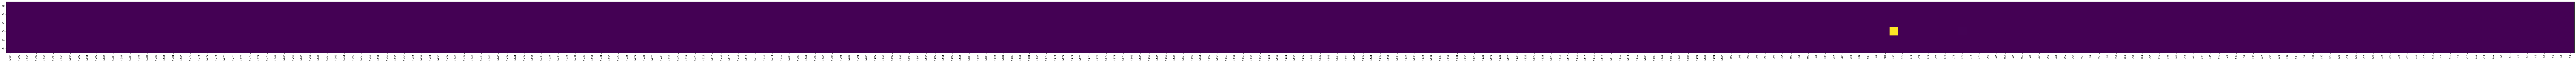

In [45]:
plt.figure(figsize=(200, 100))
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(6), ['X{}'.format(i) for i in range(6)])

### Signals with highest importance


In [55]:
#X3[t-80]

### True dependencies


In [56]:
#X4[t] += X3[t-80]/(20 + X2[t-40]) 

In [57]:
TP = 1
FP = 0
FN = 1
precision3 = TP/(TP + FP + 1e-9)
recall3 = TP/(TP + FN + 1e-9)
precision3, recall3

(0.9999999989999999, 0.49999999975)

### Predicting X5

In [46]:
y = pd.Series(X5).shift(-1).ffill().values
y = y[max_lag:]
y_train = y[:train_length]
y_test = y[train_length:]

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=256)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=256)

In [47]:

model = TCNStack(X_train_t.shape[2], 6, 6).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

loss = nn.MSELoss()

In [48]:
val_loss = 999
counter = 0

for e in range(epochs):
    train_loss = 0
    
    model.train()
    for batch_x, batch_y in tqdm_notebook(train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        output = model(batch_x)
        l = loss(output, batch_y)
        l.backward()
        opt.step()
        train_loss+=l.item()*batch_x.shape[0]
    true = []
    preds = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            output = model(batch_x)
            true.append(batch_y.numpy())
            preds.append(output.detach().cpu().numpy())
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    mse = mean_squared_error(true, preds)
    r2 = r2_score(true, preds)
    print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
    if val_loss > mse:
        val_loss = mse
        torch.save(model.state_dict(), "tcn_nonlinear_stck_X5.pt")
        counter = 0
    else:
        counter += 1

    if counter == early_stopping_epochs:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  0 train:  0.004782798846065998 mse:  0.0041962364 r2:  0.027542941422217693


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  1 train:  0.0040691073682159185 mse:  0.0041272286 r2:  0.04353504493163851


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  2 train:  0.004016099727526307 mse:  0.0040632933 r2:  0.0583516779525135


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  3 train:  0.004007844723016024 mse:  0.0040601697 r2:  0.05907565663402803


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  4 train:  0.0040076213613152506 mse:  0.004072997 r2:  0.05610300681671476


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  5 train:  0.003996778367459774 mse:  0.0040797507 r2:  0.054537894088178884


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  6 train:  0.00399082662537694 mse:  0.004056964 r2:  0.05981864736863973


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  7 train:  0.0039874068260192875 mse:  0.004051647 r2:  0.061050664872955296


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  8 train:  0.003983083292096853 mse:  0.004077647 r2:  0.05502541187646015


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  9 train:  0.003977689626812935 mse:  0.004059418 r2:  0.05924986454626324


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  10 train:  0.003978971961140633 mse:  0.004052084 r2:  0.060949445205128794


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  11 train:  0.003974072738736868 mse:  0.0040457696 r2:  0.062412902083855415


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  12 train:  0.003972909505665302 mse:  0.00406251 r2:  0.05853325584414171


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  13 train:  0.0039670055150985714 mse:  0.004075922 r2:  0.055425216892925566


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  14 train:  0.0039736100070178505 mse:  0.004128253 r2:  0.04329765776197436


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  15 train:  0.003967249045521021 mse:  0.004053981 r2:  0.060509923807599675


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  16 train:  0.003968722209334374 mse:  0.0040473556 r2:  0.0620452898610756


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  17 train:  0.00345275417342782 mse:  0.0021066559 r2:  0.5117928700756524


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  18 train:  0.001246329895593226 mse:  0.001194239 r2:  0.7232409992141151


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  19 train:  0.0010662154704332352 mse:  0.0011389575 r2:  0.7360522066692325


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  20 train:  0.0010326136631891132 mse:  0.0010532162 r2:  0.7559223425988807


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  21 train:  0.0010234456976875664 mse:  0.0010818696 r2:  0.7492820364790383


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  22 train:  0.0010026693539693951 mse:  0.0010976794 r2:  0.7456182268124858


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  23 train:  0.0010131890169344843 mse:  0.0010490522 r2:  0.7568873118058281


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  24 train:  0.000995565098337829 mse:  0.0010560979 r2:  0.7552544958687116


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  25 train:  0.000996834680531174 mse:  0.0010845386 r2:  0.748663511220446


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  26 train:  0.0009769581466913223 mse:  0.0011034267 r2:  0.7442863141553024


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  27 train:  0.0009812795852310956 mse:  0.0010978382 r2:  0.745581384488804


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  28 train:  0.000976358787342906 mse:  0.0010833988 r2:  0.7489276750889263


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  29 train:  0.0009731376547366381 mse:  0.0010580007 r2:  0.7548135699188191


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  30 train:  0.0009759884255006909 mse:  0.0010276083 r2:  0.7618568196389832


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  31 train:  0.0009693635230883956 mse:  0.001023309 r2:  0.7628531855918361


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  32 train:  0.0009689895436167717 mse:  0.0010296734 r2:  0.7613782836367029


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  33 train:  0.0009654715400189162 mse:  0.0010596609 r2:  0.7544288123027356


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  34 train:  0.0009395007746294141 mse:  0.0010346856 r2:  0.7602167065752482


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  35 train:  0.0009518524514511228 mse:  0.0010504251 r2:  0.756569167660947


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  36 train:  0.0009269040115177632 mse:  0.0010269085 r2:  0.7620190270602554


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  37 train:  0.0009159042226150631 mse:  0.0009579464 r2:  0.7780006373881322


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  38 train:  0.0007677308312617243 mse:  0.0005277407 r2:  0.8776986911661095


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  39 train:  0.00042263924074359237 mse:  0.00043356998 r2:  0.8995222942781624


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  40 train:  0.000390468968404457 mse:  0.0003965834 r2:  0.9080937469620418


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  41 train:  0.00038488133307546375 mse:  0.0004417406 r2:  0.8976287979566594


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  42 train:  0.00037057316256687046 mse:  0.00041018357 r2:  0.9049419850794489


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  43 train:  0.0003705437730066478 mse:  0.00038896114 r2:  0.9098601738837127


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  44 train:  0.00036112962127663194 mse:  0.0004067599 r2:  0.9057353887145168


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  45 train:  0.00036460633175447585 mse:  0.00038855732 r2:  0.9099537520325933


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  46 train:  0.0003544131672475487 mse:  0.00041988795 r2:  0.9026930386564839


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  47 train:  0.00035478417878039183 mse:  0.00037493126 r2:  0.913111532108091


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  48 train:  0.0003508995293173939 mse:  0.0004008921 r2:  0.907095229599159


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  49 train:  0.00035146090341731903 mse:  0.00037182902 r2:  0.9138304515015814


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  50 train:  0.00035334852216765283 mse:  0.0003725277 r2:  0.9136685410465295


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  51 train:  0.00034361742683686316 mse:  0.00038770156 r2:  0.910152074870613


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  52 train:  0.00034973827986977996 mse:  0.0005342677 r2:  0.8761860932061537


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  53 train:  0.0003490858172532171 mse:  0.00040749524 r2:  0.9055649812271106


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  54 train:  0.00034287582035176457 mse:  0.00037660115 r2:  0.9127245344512461


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  55 train:  0.0003322263680398464 mse:  0.00038395255 r2:  0.9110208891214554


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  56 train:  0.0003127027119277045 mse:  0.00033070822 r2:  0.9233599993866324


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  57 train:  0.0002446827292675152 mse:  0.00020124263 r2:  0.9533630135013549


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  58 train:  0.0001259357867296785 mse:  0.0001212023 r2:  0.9719119620162002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  59 train:  0.00010958810518495739 mse:  0.00014205989 r2:  0.9670783223042373


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  60 train:  0.00010176163272699342 mse:  0.00011330796 r2:  0.9737414402907076


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  61 train:  9.993852952029556e-05 mse:  0.00012153727 r2:  0.9718343356169225


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  62 train:  9.725598093355074e-05 mse:  0.00012021676 r2:  0.9721403584009157


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  63 train:  9.573935521766543e-05 mse:  0.00012109006 r2:  0.9719379748143949


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  64 train:  9.57823496661149e-05 mse:  0.00010217389 r2:  0.9763217019689028


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  65 train:  9.398093082709238e-05 mse:  0.00012144265 r2:  0.9718562620292466


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  66 train:  8.966167367761954e-05 mse:  0.00013567584 r2:  0.9685577912462666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  67 train:  8.934440942248329e-05 mse:  0.00010061517 r2:  0.9766829299273911


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  68 train:  8.937029327498749e-05 mse:  0.00013416255 r2:  0.9689084919102092


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  69 train:  9.350297137862072e-05 mse:  0.00011623039 r2:  0.9730641788073663


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  70 train:  8.702969774603843e-05 mse:  0.000118699376 r2:  0.9724920034931553


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  71 train:  8.773390537826344e-05 mse:  0.00011476016 r2:  0.973404899177231


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  72 train:  8.813009756850079e-05 mse:  0.00013900545 r2:  0.9677861724199698


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  73 train:  8.536535219755024e-05 mse:  0.00012322285 r2:  0.9714437091700081


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  74 train:  8.544917280087248e-05 mse:  9.721608e-05 r2:  0.9774706524071408


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  75 train:  8.617867256980389e-05 mse:  0.00010554773 r2:  0.9755398339187553


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  76 train:  8.540017566410825e-05 mse:  9.926463e-05 r2:  0.9769959085968938


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  77 train:  8.594382293522357e-05 mse:  0.00013376508 r2:  0.9690006015102436


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  78 train:  8.697104081511498e-05 mse:  0.000101854836 r2:  0.9763956439686181


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  79 train:  8.450405979529024e-05 mse:  0.00011018368 r2:  0.9744654737861357


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  80 train:  8.554303657729179e-05 mse:  0.000113328424 r2:  0.9737366946694269


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  81 train:  8.11541099450551e-05 mse:  0.00010719873 r2:  0.9751572233833155


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  82 train:  8.493614237522706e-05 mse:  0.00014592658 r2:  0.96618223432941


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  83 train:  8.474079872248695e-05 mse:  0.00010367425 r2:  0.9759740047928898


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  84 train:  7.972765665035695e-05 mse:  9.015126e-05 r2:  0.9791078884584545


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  85 train:  8.348960905568674e-05 mse:  9.507353e-05 r2:  0.9779671781750667


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  86 train:  8.734973635291681e-05 mse:  0.00012541181 r2:  0.9709364295729843


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  87 train:  8.197454274632036e-05 mse:  0.00011720327 r2:  0.9728387206104367


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  88 train:  7.922458945540712e-05 mse:  9.913905e-05 r2:  0.9770250123538711


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  89 train:  7.992899444652721e-05 mse:  9.5903684e-05 r2:  0.9777747924008569


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  90 train:  7.888969773193821e-05 mse:  0.00011596221 r2:  0.9731263293265218


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  91 train:  8.073405741015449e-05 mse:  0.00013131977 r2:  0.969567293455705


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  92 train:  7.761551446747034e-05 mse:  0.00010236867 r2:  0.976276564003847


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  93 train:  7.913098273565992e-05 mse:  0.000104343104 r2:  0.9758189984893618


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  94 train:  8.253084839088842e-05 mse:  0.000105157276 r2:  0.9756303193597626


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  95 train:  7.590628678444773e-05 mse:  9.1240545e-05 r2:  0.9788554515461079


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  96 train:  7.579515987308695e-05 mse:  9.998902e-05 r2:  0.9768280364426402


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  97 train:  7.44804329588078e-05 mse:  0.000101701145 r2:  0.9764312597027591


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  98 train:  7.842908531893045e-05 mse:  0.00011222769 r2:  0.9739917864296498


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  99 train:  7.555555742001162e-05 mse:  0.000101252124 r2:  0.9765353196472427


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  100 train:  7.612490248866379e-05 mse:  0.0001047534 r2:  0.9757239149309038


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  101 train:  7.48325970955193e-05 mse:  0.000110009576 r2:  0.974505821263158


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  102 train:  7.577258732635528e-05 mse:  0.00012208296 r2:  0.9717078746774146


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  103 train:  7.640204509953037e-05 mse:  0.0001032287 r2:  0.976077257050215


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  104 train:  7.64139610226266e-05 mse:  0.00011309703 r2:  0.9737903206951996


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  105 train:  7.348970051389188e-05 mse:  9.4536364e-05 r2:  0.9780916638926103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  106 train:  7.35146178980358e-05 mse:  0.00010057674 r2:  0.9766918359436272


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  107 train:  7.47662995941937e-05 mse:  0.00013761163 r2:  0.9681091858606596


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  108 train:  7.309547053882853e-05 mse:  9.572471e-05 r2:  0.9778162688653705


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  109 train:  7.414620983181522e-05 mse:  0.00014742785 r2:  0.9658343223710322


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  110 train:  7.543872048845514e-05 mse:  9.548512e-05 r2:  0.9778717930969486


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  111 train:  6.736144062597304e-05 mse:  0.00010015486 r2:  0.9767896037469138


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  112 train:  7.112539447844029e-05 mse:  9.77337e-05 r2:  0.9773506963599646


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  113 train:  7.305305467452854e-05 mse:  0.00011030972 r2:  0.9744362660260538


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  114 train:  7.051738238660619e-05 mse:  0.00010176255 r2:  0.9764170314649846


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  115 train:  7.063196712406353e-05 mse:  0.0001067515 r2:  0.9752608662511979


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  116 train:  6.848220488755033e-05 mse:  0.00010033356 r2:  0.976748193510351


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  117 train:  6.87127816490829e-05 mse:  0.000110911235 r2:  0.9742968677732708


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  118 train:  6.98528790497221e-05 mse:  9.5734256e-05 r2:  0.9778140574112977


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  119 train:  6.657768470468e-05 mse:  0.000107559914 r2:  0.9750735203373553


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  120 train:  6.723318106960505e-05 mse:  0.00010681807 r2:  0.9752454380216679


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  121 train:  6.936992660630494e-05 mse:  0.000108812645 r2:  0.974783206123886


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  122 train:  7.122899282258004e-05 mse:  0.00010435122 r2:  0.9758171202605135


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  123 train:  6.773302926449106e-05 mse:  0.000113704504 r2:  0.9736495397233444


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  124 train:  6.435813482385128e-05 mse:  0.00011154061 r2:  0.9741510127353864


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  125 train:  6.308035106630996e-05 mse:  9.986866e-05 r2:  0.9768559290783686


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  126 train:  6.709271369618364e-05 mse:  0.0001002829 r2:  0.9767599319832209


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  127 train:  6.61834372440353e-05 mse:  0.00014097344 r2:  0.9673300980816151


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  128 train:  6.388372560031712e-05 mse:  0.00011469561 r2:  0.9734198569455286


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  129 train:  6.407787467469461e-05 mse:  0.00010116054 r2:  0.9765565427468084


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  130 train:  6.268062583403662e-05 mse:  0.00010812009 r2:  0.9749437022697035


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  131 train:  6.087097612326033e-05 mse:  0.0001055144 r2:  0.9755475561571153


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  132 train:  6.243144433246925e-05 mse:  0.00010501409 r2:  0.9756635021914258


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  133 train:  6.271930416696705e-05 mse:  0.00010765227 r2:  0.9750521161227022


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Iter:  134 train:  6.18591804697644e-05 mse:  9.846986e-05 r2:  0.9771800929353371


In [49]:
model.load_state_dict(torch.load("tcn_nonlinear_stck_X5.pt"))

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    print(M.max())
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


tensor(0.9918, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9926, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9929, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9937, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9903, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9892, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9921, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9947, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9936, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9905, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9934, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9953, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9954, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9957, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9926, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9920, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9891, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.9901, device='cuda:0', grad_fn=<MaxBack

([<matplotlib.axis.YTick at 0x7f23fe3f1c88>,
 [Text(0, 0, 'X0'),
  Text(0, 1, 'X1'),
  Text(0, 2, 'X2'),
  Text(0, 3, 'X3'),
  Text(0, 4, 'X4'),
  Text(0, 5, 'X5')])

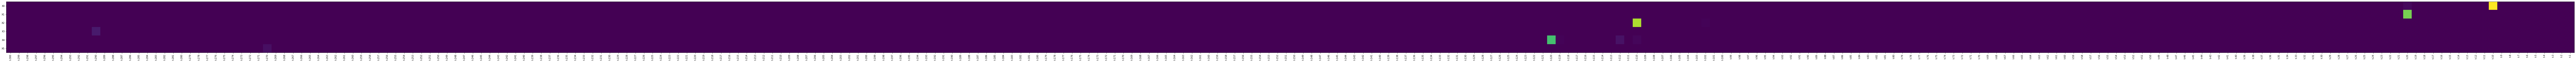

In [50]:
plt.figure(figsize=(200, 100))
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(6), ['X{}'.format(i) for i in range(6)])

### Signals with highest importance


In [58]:
#X3[t-290], #X4[t-120], #X2[t-110], #X1[t-20], #X0[t-10], X5[t-270]

### True dependencies

In [ ]:
#X5[t] += X0[t-10]*X1[t-20]+X2[t-110]*X4[t-120]+X4[t-210]*X5[t-270]

In [61]:
TP = 5
FP = 1
FN = 1
precision4 = TP/(TP + FP + 1e-9)
recall4 = TP/(TP + FN + 1e-9)
precision4, recall4

(0.8333333331944445, 0.8333333331944445)